# Encoding models tutorial
### by Giacomo Aldegheri

\
\
In this tutorial, we are going to look at encoding models, also known as *linearizing encoding*, *voxelwise encoding*, etc.

- The idea behind this approach is to measure the alignment between a model and the brain by fitting a linear regression to predict the brain response from the model's activations for the same images.
- The synthetic activations predicted from the model are then compared (generally via Pearson's correlation) to the real activations on a held-out test set.

<img src='https://drive.google.com/uc?id=1-5wQe30AqUdLFAzXvc0-v4NOzmMpjN-j' width=800>

[This recent paper](https://files.osf.io/v1/resources/t975e/providers/osfstorage/6611e05e219e71316bf6a868?format=pdf&action=download&direct&version=1) provides a nice introduction to the framework.

In this tutorial, we will use fMRI data from the [2023 Algonauts challenge](http://algonauts.csail.mit.edu/challenge.html). It is a subset of the [Natural Scenes Dataset (NSD)](https://naturalscenesdataset.org/) only including the visual system. The full dataset includes ~10'000 images per subject, but here, to make computations quicker, we will only use 872 images that were seen by all subjects.

This tutorial is heavily indebted to the following resources:

- [Algonauts 2023 Challenge tutorial](https://colab.research.google.com/drive/1bLJGP3bAo_hAOwZPHpiSHKlt97X9xsUw?usp=share_link#scrollTo=gjQrI9AlzDqG)
- [Voxelwise encoding tutorials by Matteo Visconti di Oleggio Castello (Gallant lab)](https://github.com/gallantlab/voxelwise_tutorials)
- [Deep NSD tutorial by Colin Conwell](https://colab.research.google.com/drive/1OalDuiQ6Dwg39XT-BkPMz2XAduPUxQtv?usp=sharing)
- [Leyla Tarhan's blog post on variance partitioning](http://lytarhan.rbind.io/post/variancepartitioning/)
- [Johan Carlin's blog post on noise ceiling estimation](https://www.johancarlin.com/understanding-noise-ceiling-metrics-rsa-compared-to-spearman-brown.html)

## Setup
We start by installing some libraries and importing the ones we will need

In [ ]:
!pip install nilearn==0.9.2
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

In [ ]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets, plotting
import pandas as pd
from glob import glob
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import check_cv, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from scipy.stats import sem
import random
from sentence_transformers import SentenceTransformer


In [ ]:
# Optional: uncomment if you want to use OpenAI's CLIP model:
#!pip install git+https://github.com/openai/CLIP.git
#import clip

## Quick notebook execution
It is possible that you will have to restart the notebook and execute it from scratch (e.g. sometimes the Runtime gets disconnected). Toggle this to skip execution of computationally intensive cells (e.g. 3D plots)

In [ ]:
quick_execution = False # @param {type:"boolean"}

## Set random seed for reproducibility

In [ ]:
rand_seed = 123 #@param
np.random.seed(rand_seed)
random.seed(rand_seed)
torch.manual_seed(rand_seed)

## Get data

All the data needed for this tutorial is stored on a public Google Drive folder.

You can create a shortcut to this folder in your own Google Drive, so that you don't need to copy the data ot take any space on your own Google Drive.

The public folder with the data is [here](https://drive.google.com/drive/folders/1AjDOejWLjfXGkr-hK07SZJ_4ni1nypjw?usp=sharing). You need to select the folder and choose "Add a shortcut to Drive".

<img src='https://drive.google.com/uc?id=15TNjV__sWCcnBRlxbXNbJfpidx-C6nrk' width=500>

Then, we need to 'mount' Google Drive, so that it will be possible to access files stored there (at the path `/content/drive/MyDrive/`) from this Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
main_dir = '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial' #@param {type:"string"}
fmri_dir = os.path.join(main_dir, 'fmri_data')

Mounted at /content/drive/


In [ ]:
# Make sure that the data directory is accessible
assert os.path.isdir(main_dir)

In [ ]:
# this should show the directory's content, looking like this:
#['/content/drive/MyDrive/UvA_encodingtutorial/fmri_data/subj01',
# '/content/drive/MyDrive/UvA_encodingtutorial/fmri_data/subj02',
# '/content/drive/MyDrive/UvA_encodingtutorial/fmri_data/subj03',
# etc.
glob(fmri_dir+'/*')

['/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj01',
 '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj02',
 '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj03',
 '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj04',
 '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj05',
 '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj06',
 '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj07',
 '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/fmri_data/subj08']

### Set device
If you have the possibility, using the GPU (CUDA) runtime will make computations significantly faster.

In [ ]:
device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
if device=='cuda':
  assert torch.cuda.is_available()
device = torch.device(device)

# Load and visualize the data

Great, now we're all set to start playing around with our data!

The fMRI data consists of two ```.npy``` files:
- ```lh_training_fmri.npy```: the left hemisphere (LH) fMRI data.
- ```rh_training_fmri.npy```: the right hemisphere (RH) fMRI data.

Both files are 2D arrays, where each row is a stimulus image and each column is an fMRI vertex.

For more information on the fMRI responses please check the [README.txt](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F16oLCaDmUBZuT6z_VGKO-qzwidYDE77Sg%2Fview%3Fusp%3Dshare_link) file from the 2023 Algonauts Challenge.



In [ ]:
# @title Utilities to plot ROIs and activations

def get_roi_mask(roi, hemisphere, subj):

  subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

  # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'
  elif roi == 'all-vertices':
      roi_class = roi

  # Load the ROI brain surface maps
  fsaverage_roi_class_dir = os.path.join(subj_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')

  fsaverage_roi_class = np.load(fsaverage_roi_class_dir)

  if roi != 'all-vertices':
    challenge_roi_class_dir = os.path.join(subj_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')

    challenge_roi_class = np.load(challenge_roi_class_dir)

    roi_map_dir = os.path.join(subj_dir, 'roi_masks',
        'mapping_'+roi_class+'.npy')
    roi_map = np.load(roi_map_dir, allow_pickle=True).item()

    # Select the vertices corresponding to the ROI of interest
    roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
    challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
    fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

    return challenge_roi, fsaverage_roi

  else:
    return None, fsaverage_roi_class


def plot_surf_map(subj=1, stat_map=None, hemi='left', roi=None, title=None):
  """
  Plot ROI or statistical
  """
  if roi in [None, 'all-vertices']:
    roi = 'all-vertices'

  challenge_roi, fsaverage_roi = get_roi_mask(roi, hemi, subj)


  # Map the fMRI data onto the brain surface map

  if stat_map is None:
    fsaverage_response = fsaverage_roi
    cmap = 'cool'
    colorbar = False
  else:
    fsaverage_response = np.zeros(len(fsaverage_roi))
    if roi != 'all-vertices':
      fsaverage_response[np.where(fsaverage_roi)[0][:len(np.where(challenge_roi)[0])]] = \
        stat_map[np.where(challenge_roi)[0]]
    else:
      fsaverage_response[np.where(fsaverage_roi)[0]] = \
        stat_map
    cmap = 'cold_hot'
    colorbar = True

  if title is None:
    title = roi+', '+hemi+' hemisphere'

  # Create the interactive brain surface map
  fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
  view = plotting.view_surf(
      surf_mesh=fsaverage['infl_'+hemi],
      surf_map=fsaverage_response,
      bg_map=fsaverage['sulc_'+hemi],
      threshold=1e-14,
      cmap=cmap,
      colorbar=colorbar,
      title=title
      )
  return view

In [ ]:
# @title Choose subject to visualize:
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

lh_fmri = np.load(os.path.join(subj_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(subj_dir, 'rh_training_fmri.npy'))

print('LH fMRI data shape:')
print(lh_fmri.shape)
print('(Stimulus images × LH vertices)')

print('\nRH fMRI data shape:')
print(rh_fmri.shape)
print('(Stimulus images × RH vertices)')

LH fMRI data shape:
(872, 19004)
(Stimulus images × LH vertices)

RH fMRI data shape:
(872, 20544)
(Stimulus images × RH vertices)


In [ ]:
# @title Visualize all vertices on a brain surface map
if not quick_execution:
  hemisphere = 'left' #@param ['left', 'right']
  view = plot_surf_map(subj=subj, hemi=hemisphere)
else:
  view = 'Skipping plot (untoggle quick execution to show plot)'
view

Output hidden; open in https://colab.research.google.com to view.

## Visualize a chosen ROI on the surface

In [ ]:
if not quick_execution:
  hemisphere = 'left' #@param ["left", "right"]
  roi = "ventral" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]
  view = plot_surf_map(subj=subj, hemi=hemisphere, roi=roi)
else:
  view = 'Skipping plot (untoggle quick execution to show plot)'
view

Output hidden; open in https://colab.research.google.com to view.

## Stimulus images

Now, let's look at the images subjects were seeing in the scanner. All images come from the [COCO dataset](https://cocodataset.org/#home) of natural scenes.

In [ ]:
stim_dir = os.path.join(main_dir, 'stimuli')

# Create lists with all training and test image file names, sorted
img_list = os.listdir(stim_dir)
img_list.sort()
print('Total n. of images: ' + str(len(img_list)))

Total n. of images: 872


## Visualize the fMRI response to selected images

Select an image, and see the fMRI response of our participant to that image, across all vertices included in the dataset.

- => preprocessd and only for the visual cortex

In [ ]:
if not quick_execution:
  img = 0 #@param

  #Load the image
  img_file = os.path.join(stim_dir, img_list[img])
  this_img = Image.open(img_file).convert('RGB')

  plt.figure()
  plt.axis('off')
  plt.imshow(this_img)
  plt.title('Image: ' + str(img));

  stat_map = lh_fmri[img] if hemisphere == 'left' else rh_fmri[img]

  view = plot_surf_map(stat_map=stat_map, subj=subj, hemi=hemisphere)
else:
  view = 'Skipping plot (untoggle quick execution to show plot)'
view

Output hidden; open in https://colab.research.google.com to view.

## Visualize the fMRI responses of a chosen ROI

In [ ]:
if not quick_execution:

  img = 10 #@param
  hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
  roi = "early" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

  # Load the image
  img_file = os.path.join(stim_dir, img_list[img])
  this_img = Image.open(img_file).convert('RGB')

  # Plot the image
  plt.figure()
  plt.axis('off')
  plt.imshow(this_img)
  plt.title('Training image: ' + str(img+1));

  stat_map = lh_fmri[img] if hemisphere == 'left' else rh_fmri[img]

  view = plot_surf_map(stat_map=stat_map, subj=subj, hemi=hemisphere, roi=roi)

else:
  view = 'Skipping plot (untoggle quick execution to show plot)'

view

Output hidden; open in https://colab.research.google.com to view.

# Extract and downsample image features from deep models

Deep neural networks are the de facto standard for any computer vision task these days. They can be seen as hierarchical feature extractors, with activation patterns at different layers corresponding to different levels of image descriptions: from edge orientations, to object parts, to full objects.

<img src='https://drive.google.com/uc?id=1-E0TygS1BIYop-a_9mTwNk7xSSOQ_Das' width=600>

Figure by [Pantelis Monogioudis](https://pantelis.github.io/cs677/docs/common/lectures/deep-learning-introduction/)

\
Here, we extract the activations from one or more specified layers of a **convolutional neural network (CNN)**. For example, we can extract the activations of a *convolutional* layer (which have shape `width x height x number of channels`), and then flatten them into a vector, or extract the activations from a *fully-connected* layer, typically one of the final layers of the network, which are already flattened:

<img src='https://drive.google.com/uc?id=1zKWFWwOTtkBVwmj_MzJNK9lTmyrwfMVW' width=700>

Figure from [here](https://www.analyticsvidhya.com/blog/2022/03/basic-introduction-to-convolutional-neural-network-in-deep-learning/)

\
Either way, the intermediate activations of deep neural networks such as [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) are typically very high-dimensional. For example, here by default we are using the activations of the convolutional layer `features.2`, which has 64 * 27 * 27 = 46656 dimensions (height x width x channels of the convolutional activation map).

With so many dimensions, and relatively few datapoints (785 training images), it's likely that the network will [*overfit*](https://en.wikipedia.org/wiki/Overfitting) to the training data. In a nutshell, this means that the high number of features will allow the network to perfectly learn the idiosyncrasies of the training set, at the cost of generalization to the test set.

To avoid this issue, we use [principal component analysis](https://peterbloem.nl/blog/pca) (PCA), the most common form of dimensionality reduction. We reduce the dimensions to 100, a more reasonable number.

\
**NOTE:** this is just a ballpark estimate of the number of dimensions. A more principled approach would be to set a threshold proportion (e.g. 90%) of variance explained in the original data (network activations) and use the number of dimensions needed to reach that (e.g. see [this tutorial](https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/Multivariate-Approaches/Principal-Component-Analysis/PCA-the-basics/Choose-Principal-Components/index.html#:~:text=A%20widely%20applied%20approach%20is,elbow%20in%20the%20scree%20plot.)). Here, we don't need to worry about that.

In [ ]:
# @title Helper functions to obtain a model and extract its activations

def get_vision_model(whichmodel):
  """
  Get computer vision model. This function can be
  modified to return a custom model.
  """
  if whichmodel in ['alexnet', 'resnet50']:
    model = torch.hub.load('pytorch/vision:v0.10.0', whichmodel)
    preprocess = transforms.Compose([
      transforms.Resize((224,224)), # resize the images to 224x24 pixels
      transforms.ToTensor(), # convert the images to a PyTorch tensor
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
    ])
  elif whichmodel=='clip':
    model, preprocess = clip.load("ViT-B/32")
  else:
    raise ValueError(f'Model {whichmodel} unknown!')

  return model, preprocess


def list_layers(model):
    """
    List all layers of the model with their names.
    """
    layers = []
    for name, mod in model.named_modules():
        layers.append(name)
    return layers


def register_hooks(model, target_layers):
    """
    Register hooks to extract features from specified layers.
    """
    if not isinstance(target_layers, list):
      target_layers = [target_layers]

    features = {}

    def get_hook(name):
        def hook(module, input, output):
            features[name] = output.detach()
        return hook

    for name, layer in model.named_modules():
        if name in target_layers:
            layer.register_forward_hook(get_hook(name))

    return features

In [ ]:
class FeatureExtractor():
  """
  Wrapper for the feature extractor.
  Loads a specified model and calls it on an input image,
  returning the activations for the desired layer(s).
  """
  def __init__(self, modelname, device=device, target_layers=None):
    self.modelname = modelname
    self.device = device
    model, self.preprocess = get_vision_model(modelname)
    self.model = model.eval().to(self.device)
    if target_layers is not None:
      self.create_feature_extractor(target_layers)

  def create_feature_extractor(self, target_layers):
    self.target_layers = target_layers
    self.features = register_hooks(self.model, self.target_layers)

  def list_layers(self):
    return list_layers(self.model)

  def run_model(self, x):

    x = x.to(self.device)

    with torch.no_grad():
      _ = self.model.encode_image(x) if self.modelname=='clip' else self.model(x)

  def __call__(self, x):
    self.run_model(x)
    features = torch.hstack([torch.flatten(l, start_dim=1) for l in self.features.values()])

    return features.detach().cpu().numpy()

## Create the feature extractor for a specified model and layer(s).

Here, we use our `FeatureExtractor` class to create a feature extractor that takes images as input, and extracts the activations (features) of the desired layer(s) (`target_layers`) from those images.

Please note that `target_layers` can be a single string, but also a list of layers. In that case, the layers' activations are concatenated before applying PCA. To find out what layers are available for a given model, you can do the following:



```
# Note that we don't pass the 'target_layers'
# as a parameter to add them later!
feat_extractor = FeatureExtractor(modelname, device=device)

feat_extractor.list_layers()
```
 After choosing one or multiple layers from the list, you can do:

```
feat_extractor.create_feature_extractor(target_layers)
```

Up to you to experiment and try different layers and models! You can search the literature for ideas.


In [ ]:
# @title Choose model and layer(s)
modelname = 'alexnet' #@param ['alexnet', 'resnet50', 'clip'] {allow-input: true}
target_layers = 'features.2' #@param {type: 'string'}

In [ ]:
# Note that we don't pass the 'target_layers'
# as a parameter to add them later!
feat_extractor = FeatureExtractor(modelname, device=device)

feat_extractor.list_layers()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


['',
 'features',
 'features.0',
 'features.1',
 'features.2',
 'features.3',
 'features.4',
 'features.5',
 'features.6',
 'features.7',
 'features.8',
 'features.9',
 'features.10',
 'features.11',
 'features.12',
 'avgpool',
 'classifier',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6']

In [ ]:
# Create the feature extractor
feat_extractor = FeatureExtractor(modelname, device=device, target_layers=target_layers)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


## Use PCA to reduce the dimensionality of the extracted features

Here, we define the functions that fit our PCA to the training set, and apply it to the test set. We use the [Incremental PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html) from `scikit-learn`, which is fit to the data in batches rather than all at the same time, to be more memory-efficient.

In [ ]:
def fit_pca(feature_extractor, dataloader, n_components=100, batch_size=500):

  # Define PCA parameters (n. components, batch size)
  pca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

  # Fit PCA to batch
  for d in tqdm(dataloader, total=len(dataloader)):
    # Extract features
    ft = feature_extractor(d)

    # Fit PCA to batch
    pca.partial_fit(ft)

  return pca

In [ ]:
def extract_features(feature_extractor, dataloader, pca=None):
  """
  Given a FeatureExtractor object, a dataloader,
  and optionally a PCA, return the
  (dimensionality-reduced) features.
  """

  features = []
  for d in tqdm(dataloader, total=len(dataloader)):
    # Extract features
    ft = feature_extractor(d)

    if pca is not None:
      # Apply PCA transform (optional)
      ft = pca.transform(ft)
    features.append(ft)

  return np.vstack(features)

## Create image dataset

This Pytorch dataset provides images to the model, and applies the relevant preprocessing transformations.

In [ ]:
class ImageDataset(Dataset):
    """
    Pytorch dataset that loads the images
    from our stimulus set.
    """
    def __init__(self, imgs_paths, idxs, transform, device=device):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(self.device)
        return img

### Split fMRI data into training and test partitions

For the moment, we will analyze a single subject. We specify which subject we want to analyze, and load their fMRI data.


We assign 90% of our 872 images to the training set, and the remaining 10% to the test set. This will be our train-test partition for the rest of the tutorial.

In [ ]:
# @title Choose subject to analyze:
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

lh_fmri = np.load(os.path.join(subj_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(subj_dir, 'rh_training_fmri.npy'))

print('LH fMRI data shape:')
print(lh_fmri.shape)
print('(Stimulus images × LH vertices)')

print('\nRH fMRI data shape:')
print(rh_fmri.shape)
print('(Stimulus images × RH vertices)')

LH fMRI data shape:
(872, 19004)
(Stimulus images × LH vertices)

RH fMRI data shape:
(872, 20544)
(Stimulus images × RH vertices)


In [ ]:


# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(img_list) / 100 * 90))
# Shuffle all stimulus images
idxs = np.arange(len(img_list))
np.random.shuffle(idxs)

# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_test = idxs[:num_train], idxs[num_train:]

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 785

Test stimulus images: 87


In [ ]:
# Partition the fMRI data for the two hemispheres

lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_test = lh_fmri[idxs_test]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_test = rh_fmri[idxs_test]

# Delete the original data arrays to free memory
del lh_fmri, rh_fmri

In [ ]:
batch_size = 200 #@param
# Get the paths of all image files
imgs_paths = sorted(list(Path(stim_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_train, transform=feat_extractor.preprocess),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_test, transform=feat_extractor.preprocess),
    batch_size=batch_size
)

In [ ]:
# @title Fit PCA with desired number of components

n_components = 100 # @param

pca = fit_pca(feat_extractor, train_imgs_dataloader,
              n_components=n_components, batch_size=100)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
pca

IncrementalPCA(batch_size=100, n_components=100)

## Linearly map the DNN image features  to fMRI responses

Now that we have fit our PCA, we can try using our dimensionality-reduced features to predict the fMRI responses! We will use a simple linear regression for that, and then measure the Pearson correlation between the predicted and real fMRI responses on the test set.

<img src='https://drive.google.com/uc?id=1--rx8qPyuhH37uG53MjAOdS_nGdoK5q0' width=800>

Figure from the [2023 Algonauts challenge tutorial](https://colab.research.google.com/drive/1bLJGP3bAo_hAOwZPHpiSHKlt97X9xsUw?usp=share_link)

In [ ]:
features_train = extract_features(feat_extractor, train_imgs_dataloader, pca)
features_test = extract_features(feat_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_test.shape)
print('(Validation stimulus images × PCA features)')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Training images features:
(785, 100)
(Training stimulus images × PCA features)

Validation images features:
(87, 100)
(Validation stimulus images × PCA features)


In [ ]:
# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)

# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_test)

## Evaluate and visualize the encoding model's prediction accuracy (i.e., encoding accuracy) using the test partition

### Compute the encoding accuracy through a Pearson's correlation

Here you will compute your encoding model's prediction accuracy (or encoding accuracy) through a Pearson correlation between the predicted and ground truth fMRI test partition data. The correlation scores indicate how similar the predicted fMRI data is to the ground truth data, namely how accurate your encoding model is in predicting (encoding) fMRI responses to images.

Specifically, you will correlate the activity of each predicted fMRI vertex with the activity of the corresponding ground truth fMRI vertex, across the test partition stimulus images.

In [ ]:
def compute_correlation(X, Y):
  """
  Our main correlation function. Computes the Pearson correlation
  between *columns* of two arrays X and Y. In our case, that
  corresponds to correlation between a specific vertex's activations
  across images.
  """

  X = X - np.mean(X, axis=0)
  Y = Y - np.mean(Y, axis=0)

  covariance = np.sum(X * Y, axis=0)

  std_dev_X = np.sqrt(np.sum(X**2, axis=0))
  std_dev_Y = np.sqrt(np.sum(Y**2, axis=0))

  correlations = covariance / (std_dev_X * std_dev_Y)

  return correlations

In [ ]:
# Correlation arrays of shape: (# vertices)
lh_correlation = compute_correlation(lh_fmri_val_pred, lh_fmri_test)
rh_correlation = compute_correlation(rh_fmri_val_pred, rh_fmri_test)

print(lh_fmri_val_pred.shape)
print(lh_correlation.shape, '\n', rh_correlation.shape)

(87, 19004)
(19004,) 
 (20544,)


### Visualize the encoding accuracy of all vertices on a brain surface map

We visualize the encoding accuracy of all vertices on a brain surface map. For this we need to map each vertex of the correlation results (in `challenge space`) to the corresponding vertices on the brain surface template (in `fsaverage space`).

You need to choose the hemisphere (`'left'` or `'right'`) you want to visualize.

In [ ]:
if not quick_execution:

  hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

  stat_map = lh_correlation if hemisphere == 'left' else rh_correlation

  view = plot_surf_map(stat_map=stat_map, subj=subj,
                       hemi=hemisphere)
else:
  view = 'Skipping plot (untoggle quick execution to show plot)'
view

Output hidden; open in https://colab.research.google.com to view.

What can you notice in the resulting map? Which parts of the visual cortex seem to be best predicted?

## Average prediction accuracy across subjects for early and late visual ROIs

Now, we move beyond a single subject to our full sample of 8 subjects. We also narrow down our analysis to two specific ROIs: early visual cortex and ventral visual cortex.

In [ ]:
def fit_and_predict(subj, features_train, features_test, train_idxs, test_idxs,
                    regression=LinearRegression()):
  """
  Given a subject ID, train and test features, and a regression model,
  this function loads the relevant fMRI data, fits the regression on it
  and computes the prediction accuracy of the fitted model.
  It also returns the fitted regressions - we don't need this now, but we
  will later!
  """

  subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

  lh_fmri = np.load(os.path.join(subj_dir, 'lh_training_fmri.npy'))
  rh_fmri = np.load(os.path.join(subj_dir, 'rh_training_fmri.npy'))

  lh_fmri_train = lh_fmri[train_idxs]
  lh_fmri_test = lh_fmri[test_idxs]
  rh_fmri_train = rh_fmri[train_idxs]
  rh_fmri_test = rh_fmri[test_idxs]

  # Fit linear regressions on the training data
  reg_lh = clone(regression)
  reg_rh = clone(regression)

  reg_lh = reg_lh.fit(features_train, lh_fmri_train)
  reg_rh = reg_rh.fit(features_train, rh_fmri_train)

  # Use fitted linear regressions to predict the validation fMRI data
  lh_fmri_test_pred = reg_lh.predict(features_test)
  rh_fmri_test_pred = reg_rh.predict(features_test)

  # Correlate predicted and ground-truth values
  lh_corrs = compute_correlation(lh_fmri_test_pred, lh_fmri_test)
  rh_corrs = compute_correlation(rh_fmri_test_pred, rh_fmri_test)

  return lh_corrs, rh_corrs, reg_lh, reg_rh


In [ ]:
def barplot(data, x='roi', y='mean_corr', hue='hemisphere', title=None, noise_ceilings=None):
  """
  Function to show a barplot with an additional
  (optional) noise ceiling
  """

  ax = sns.barplot(x=x, hue=hue, y=y, errorbar=('ci', 68), data=data)

  if noise_ceilings is not None:
    upper_lim = max([nc[1] for nc in noise_ceilings]) + 0.1
    ax.set_ylim(0, upper_lim)

    bar_width = [b.get_width() for b in ax.patches if b.get_width() != 0][0]

    noiseceil_idx = 0

    for i, roi in enumerate(prediction_df['roi'].unique()):

      nc1 = noise_ceilings[noiseceil_idx]
      left1 = i - bar_width
      bottom1 = nc1[0]

      ax.add_patch(plt.Rectangle((left1, bottom1), bar_width-0.01, nc1[1]-nc1[0], color='grey',
                                 alpha=0.3))

      nc2 = noise_ceilings[noiseceil_idx+1]
      left2 = i
      bottom2 = nc2[0]

      ax.add_patch(plt.Rectangle((left2, bottom2), bar_width-0.01, nc1[1]-nc1[0], color='grey',
                                 alpha=0.3))

      noiseceil_idx += 2

  plt.title(title)
  plt.show()

In [ ]:
roi_1 = 'early' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
roi_2 = 'ventral' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

prediction_df = []

for subj in tqdm(range(1, 9)):

  lh_corrs, rh_corrs, _, _ = fit_and_predict(subj, features_train, features_test,
                                       idxs_train, idxs_test)
  roi1_lh = get_roi_mask(roi_1, 'lh', subj)[0][:len(lh_corrs)]
  roi2_lh = get_roi_mask(roi_2, 'lh', subj)[0][:len(lh_corrs)]
  roi1_rh = get_roi_mask(roi_1, 'rh', subj)[0][:len(rh_corrs)]
  roi2_rh = get_roi_mask(roi_2, 'rh', subj)[0][:len(rh_corrs)]

  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(lh_corrs[np.where(roi1_lh)[0]]),
      'hemisphere': 'left',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(rh_corrs[np.where(roi1_rh)[0]]),
      'hemisphere': 'right',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(lh_corrs[np.where(roi2_lh)[0]]),
      'hemisphere': 'left',
      'roi': roi_2
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(rh_corrs[np.where(roi2_rh)[0]]),
      'hemisphere': 'right',
      'roi': roi_2
  })

prediction_df = pd.DataFrame(prediction_df)

  0%|          | 0/8 [00:00<?, ?it/s]

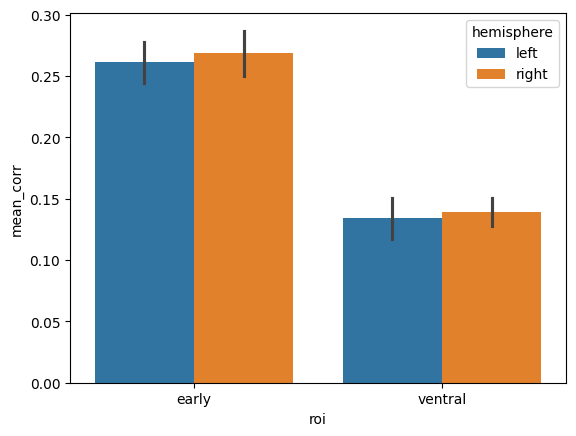

In [ ]:
barplot(prediction_df)

We can see that the prediction is quite good in early visual cortex, less so in later ventral visual cortex.

# Across-subject noise ceiling

What do the correlations we have found mean? Let's find out what's the *maximum* correlation we can obtain from our data. How? A common approach is described [here](https://www.johancarlin.com/understanding-noise-ceiling-metrics-rsa-compared-to-spearman-brown.html).

- We estimate a *lower noise ceiling* by correlating the activations of a held-out subject to the mean activations of the remaining $N-1$ subjects. This is an under-estimate of the true maximum correlation.

- And we estimate an *upper noise ceiling* by correlating the activations of each subject to the mean activations of all subjects, *including* that subject. This is an over-estimate of the true maximum correlation.

We estimate both of these across all participants, and take the average.
The true noise ceiling will lie somewhere in between these two extremes. Because we are fitting parameters (in our linear regression) before estimating the predicted-real correlation, for a fair comparison we need to fit a linear regression here as well (as explained in [this paper](https://www.sciencedirect.com/science/article/pii/S105381192200413X)). We thus try to predict each subject as a linear function of the average across all or all other subjects.
\
\
**NOTE:** while this is a standard approach in RSA (as you will see tomorrow), usually in encoding models it's more common to estimate noise ceilings *within* participants, using the variance across presentations of the same stimulus as a measure of noise. See for example the [NSD paper](https://www.nature.com/articles/s41593-021-00962-x) or [this tutorial](https://github.com/gallantlab/voxelwise_tutorials/blob/main/tutorials/notebooks/shortclips/01_plot_explainable_variance.ipynb). Here, for simplicity and consistency with tomorrow's RSA tutorial, we choose the across-subject approach instead.



In [ ]:
def compute_noise_ceiling(roi, hemi, regression=LinearRegression()):

  # Pre-load the data
  all_responses = []

  for s in range(1, 9):
    subj_dir = os.path.join(fmri_dir, f'subj{s:02d}')

    fmri_resp = np.load(os.path.join(subj_dir, f'{hemi}_training_fmri.npy'))

    challenge_roi, fsaverage_roi = get_roi_mask(roi, hemi, s)

    fsaverage_response = np.zeros((len(fmri_resp), len(fsaverage_roi)))
    if s == 1:
      common_roi = fsaverage_roi
    else:
      common_roi *= fsaverage_roi
    fsaverage_response[:, np.where(fsaverage_roi)[0]] = \
        fmri_resp[:, np.where(challenge_roi)[0]]

    all_responses.append(fsaverage_response)

  all_responses = [resp[:, np.where(common_roi)[0]] for resp in all_responses]
  all_responses = np.dstack(all_responses)

  num_train = int(np.round(len(fmri_resp) / 100 * 90))

  all_subjs = np.mean(all_responses, axis=2)

  all_correlations_lower = []
  all_correlations_upper = []

  for s in tqdm(range(0, 8)):
    this_subj = all_responses[:, :, s]

    other_subjs = np.dstack([all_responses[:, :, :s],
                            all_responses[:, :, s+1:]])
    other_subjs = np.mean(other_subjs, axis=2)

    reg_lower = clone(regression)
    reg_upper = clone(regression)

    reg_lower = reg_lower.fit(this_subj[:num_train],
                              other_subjs[:num_train])
    reg_upper = reg_upper.fit(this_subj[:num_train],
                              all_subjs[:num_train])

    other_subjs_pred = reg_lower.predict(this_subj[num_train:])
    all_subjs_pred = reg_upper.predict(this_subj[num_train:])

    del reg_lower, reg_upper

    corrs_lower = compute_correlation(other_subjs_pred,
                                      other_subjs[num_train:])
    corrs_upper = compute_correlation(all_subjs_pred,
                                      all_subjs[num_train:])

    all_correlations_lower.append(np.mean(corrs_lower))
    all_correlations_upper.append(np.mean(corrs_upper))

    lower = np.mean(all_correlations_lower)
    upper = np.mean(all_correlations_upper)

  return (lower, upper)

Let's compute the noise ceilings for each of our two ROIs and hemispheres! Please note that this part might be a bit time-consuming to run (~14 minutes with a GPU backend). If you choose the `quick_execution` option, we will simply load precomputed noise ceilings.

In [ ]:
if not quick_execution:
  # Compute the noise ceiling for each ROI and hemisphere
  all_noiseceilings = []
  for roi in [roi_1, roi_2]:
    for hemi in ['lh', 'rh']:
      this_nc = compute_noise_ceiling(roi, hemi)
      print(roi, hemi, this_nc)
      all_noiseceilings.append(this_nc)
  all_noiseceilings = np.vstack(all_noiseceilings)
else:
  assert roi_1=='early' and roi_2=='ventral', 'Precomputed noise ceilings are only for the default ROIs, early and ventral!'
  all_noiseceilings = np.loadtxt(os.path.join(main_dir, 'additional_data', 'all_noiseceilings.txt'))

  0%|          | 0/8 [00:00<?, ?it/s]

early lh (0.3797895074617341, 0.4816558550478959)


  0%|          | 0/8 [00:00<?, ?it/s]

early rh (0.39002506624927236, 0.49227303351655716)


  0%|          | 0/8 [00:00<?, ?it/s]

ventral lh (0.4051744229765014, 0.4992868786350216)


  0%|          | 0/8 [00:00<?, ?it/s]

ventral rh (0.4243332704879702, 0.5173365116250191)


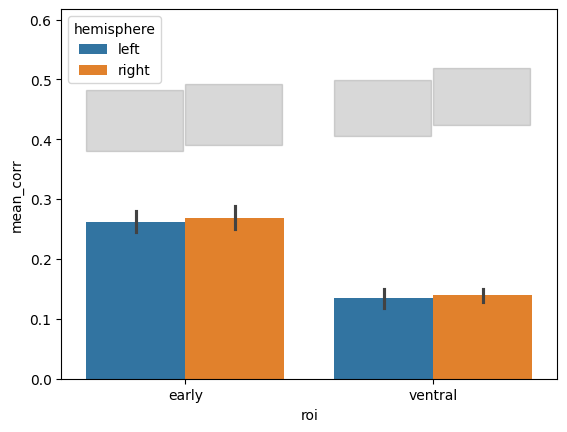

In [ ]:
# Plot again, this time with noise ceilings
barplot(prediction_df, noise_ceilings=all_noiseceilings)

We can see that in early visual cortex, we are not *too* far from the noise ceiling! In ventral visual cortex, however, there's still quite some margin for improvement.

# Ridge regression

This section is based on [this tutorial](https://github.com/gallantlab/voxelwise_tutorials/blob/main/tutorials/notebooks/shortclips/02_plot_ridge_regression.ipynb) by the Gallant Lab.

\


We now take a step back from this complex fMRI data, and go back to "first principles".

Linear regression is a method to model the relation between some input variables $X \in \mathbb{R}^{n \times p}$ and an output variable $y \in \mathbb{R}^n$ (the target). Specifically, linear regression uses a vector of coefficients $w \in \mathbb{R}^p$ to predict the output:
$$
\hat{y} = Xw
$$

The "vanilla" linear regression we have been using is known as *ordinary least squares* (OLS), and it simply looks for the vector $w$ that minimizes the sum of squared errors between predictions and targets:

$$
w = \arg \min_{w}||Xw-y||^2
$$

In many cases, though, we want to constrain the parameter vector $w$ by adding a second term to the loss function to be minimize. This second term *regularizes* the regression, preventing over-fitting. Ridge regression is a commonly used example of such regularization.

In [ ]:
# @title Utility functions

COEFS = np.array([0.4, 0.3])

def create_regression_toy(n_samples=50, n_features=2, noise=0.3, correlation=0,
                          random_state=0):
    """Create a regression toy dataset."""
    if n_features > 2:
        raise ValueError("n_features must be <= 2.")

    # create features
    rng = np.random.RandomState(random_state)
    X = rng.randn(n_samples, n_features)
    X -= X.mean(0)
    X /= X.std(0)

    # makes correlation(X[:, 1], X[:, 0]) = correlation
    if n_features == 2:
        X[:, 1] -= (X[:, 0] @ X[:, 1]) * X[:, 0] / (X[:, 0] @ X[:, 0])
        X /= X.std(0)
        if correlation != 0:
            X[:, 1] *= np.sqrt(correlation ** (-2) - 1)
            X[:, 1] += X[:, 0] * np.sign(correlation)
        X /= X.std(0)

    # create linear coefficients
    w = COEFS[:n_features]

    # create target
    y = X @ w
    y += rng.randn(*y.shape) * noise

    return X, y

def l2_loss(X, y, w):
    if w.ndim == 1:
        w = w[:, None]
    return np.sum((X @ w - y[:, None]) ** 2, axis=0)


def ridge(X, y, alpha):
    n_features = X.shape[1]
    return np.linalg.solve(X.T @ X + np.eye(n_features) * alpha, X.T @ y)

def plot_1d(X, y, w):
    w = np.atleast_1d(w)

    fig, axes = plt.subplots(1, 2, figsize=(6.7, 2.5))

    # left plot: y = f(x)
    ax = axes[0]
    ax.scatter(X, y, alpha=0.5, color="C0")
    ylim = ax.get_ylim()
    ax.plot([X.min(), X.max()], [X.min() * w[0], X.max() * w[0]], color="C1")
    ax.set(xlabel="X[:, 0]", ylabel="y", ylim=ylim)
    ax.grid()
    for xx, yy in zip(X[:, 0], y):
        ax.plot([xx, xx], [yy, xx * w[0]], c='gray', alpha=0.5)

    # right plot: loss = f(w)
    ax = axes[1]
    w_range = np.linspace(-0.1, 0.8, 100)
    ax.plot(w_range, l2_loss(X, y, w_range[None]), color="C2")
    ax.scatter([w[0]], l2_loss(X, y, w), color="C1")
    ax.set(xlabel="w[0]", ylabel="Squared loss")
    ax.grid()

    fig.tight_layout()
    plt.show()


def plot_2d(X, y, w, flat=True, alpha=None, show_noiseless=True):
    from mpl_toolkits import mplot3d  # noqa
    w = np.array(w)

    fig = plt.figure(figsize=(6.7, 2.5))

    #####################
    # left plot: y = f(x)

    try:  # computed_zorder is only available in matplotlib >= 3.4
        ax = fig.add_subplot(121, projection='3d', computed_zorder=False)
    except AttributeError:
        ax = fig.add_subplot(121, projection='3d')

    # to help matplotlib displays scatter points behind any surface, we
    # first plot the point below, then the surface, then the points above,
    # and use computed_zorder=False.
    above = y > X @ w
    ax.scatter3D(X[~above, 0], X[~above, 1], y[~above], alpha=0.5, color="C0")

    xmin, xmax = X.min(), X.max()
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 10),
                         np.linspace(xmin, xmax, 10))
    ax.plot_surface(xx, yy, xx * w[0] + yy * w[1], color=[0, 0, 0, 0],
                    edgecolor=[1., 0.50, 0.05, 0.50])

    # plot the point above *after* the surface
    ax.scatter3D(X[above, 0], X[above, 1], y[above], alpha=0.5, color="C0")

    ax.set(xlabel="X[:, 0]", ylabel="X[:, 1]", zlabel="y",
           zlim=[yy.min(), yy.max()])

    #########################
    # right plot: loss = f(w)
    if flat:
        ax = fig.add_subplot(122)

        if alpha is not None:
          w_ols = np.linalg.solve(X.T @ X, X.T @ y)
          wmin = np.min(np.vstack([w_ols, w]), axis=0)
          wmax = np.max(np.vstack([w_ols, w]), axis=0)
          left_bound = -0.1 if wmin[0] >= -0.1 else wmin[0] - 0.1
          right_bound = 0.9 if wmax[0] < 0.9 else wmax[0] + 0.1
          down_bound = -0.1 if wmin[1] >= -0.1 else wmin[1] - 0.1
          up_bound = 0.9 if wmax[1] < 0.9 else wmax[1] + 0.1
        else:
          left_bound = -0.1 if w[0] >= -0.1 else w[0] - 0.1
          right_bound = 0.9 if w[0] < 0.9 else w[0] + 0.1
          down_bound = -0.1 if w[1] >= -0.1 else w[1] - 0.1
          up_bound = 0.9 if w[1] < 0.9 else w[1] + 0.1
        w0, w1 = np.meshgrid(np.linspace(left_bound, right_bound, 100),
                             np.linspace(down_bound, up_bound, 100))
        w_range = np.stack([w0.ravel(), w1.ravel()])
        zz = l2_loss(X, y, w_range).reshape(w0.shape)
        # zz_reg = (w_range ** 2).sum(0).reshape(w0.shape) * alpha
        ax.imshow(zz, extent=(w0.min(), w0.max(), w1.min(), w1.max()),
                  origin="lower")
        im = ax.contourf(w0, w1, zz, levels=20, vmax=zz.max(),
                         extent=(w0.min(), w0.max(), w1.min(), w1.max()),
                         origin="lower")

        ax.scatter([w[0]], [w[1]], color="C1", s=[20], label="w")
        if show_noiseless:
            ax.scatter([COEFS[0]], [COEFS[1]], color="r", s=[20], marker="x",
                       label="w_noiseless")
            if alpha is not None:
                ax.scatter([w_ols[0]], [w_ols[1]], color="C3", s=[20],
                           marker="o", label="w_OLS")
            ax.legend(framealpha=0.2)

        if alpha is not None:
            xlim, ylim = ax.get_xlim(), ax.get_ylim()
            angle = np.linspace(-np.pi, np.pi, 100)
            radius = np.sqrt(np.sum(w ** 2))
            ax.plot(np.cos(angle) * radius, np.sin(angle) * radius, c='k')
            ax.set_xlim(xlim), ax.set_ylim(ylim)

        ax.set(xlabel="w[0]", ylabel="w[1]")
        cbar = plt.colorbar(im, ax=ax)
        cbar.ax.set(ylabel="Squared loss")

    else:  # 3D version of the right plot
        ax = fig.add_subplot(122, projection='3d')
        w0, w1 = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
        w_range = np.stack([w0.ravel(), w1.ravel()])
        zz = l2_loss(X, y, w_range).reshape(w0.shape)
        ax.plot_surface(w0, w1, zz, color="C2", alpha=0.4, edgecolor='gray')
        ax.scatter3D([w[0]], [w[1]], [l2_loss(X, y, w)], color="C1")
        ax.set(xlabel="w[0]", ylabel="w[1]", zlabel="Squared loss")

    fig.tight_layout()
    plt.show()


def plot_kfold2(X, y, alpha=0, fit=True, flip=False):
    half = X.shape[0] // 2

    if not fit:
        fig, ax = plt.subplots(1, 1, figsize=(3.4, 2.5))
        ax.scatter(X[:half], y[:half], alpha=0.5, color="C0")
        ax.scatter(X[half:], y[half:], alpha=0.5, color="C1")
        ax.set(xlabel="x1", ylabel="y")
        ax.grid()
        fig.tight_layout()
        plt.show()
        return None

    fig, axes = plt.subplots(1, 2, figsize=(6.7, 2.5), sharex=True,
                             sharey=True)

    w_ridge1 = ridge(X[:half], y[:half], alpha)
    w_ridge2 = ridge(X[half:], y[half:], alpha)

    ax = axes[0]
    if not flip:
        ax.scatter(X[:half], y[:half], alpha=0.5, color="C0")
    else:
        ax.scatter(X[half:], y[half:], alpha=0.5, color="C1")
    ax.plot([X.min(), X.max()],
            [X.min() * w_ridge1, X.max() * w_ridge1], color="C0")
    ax.set(xlabel="X[:, 0]", ylabel="y", title='model 1')
    ax.grid()

    ax = axes[1]
    if flip:
        ax.scatter(X[:half], y[:half], alpha=0.5, color="C0")
    else:
        ax.scatter(X[half:], y[half:], alpha=0.5, color="C1")
    ax.plot([X.min(), X.max()],
            [X.min() * w_ridge2, X.max() * w_ridge2], color="C1")
    ax.set(xlabel="X[:, 0]", ylabel="y", title='model 2')
    ax.grid()

    fig.tight_layout()
    plt.show()


def plot_cv_path(X, y):
    losses = []
    alphas = np.logspace(-2, 4, 12)

    half = X.shape[0] // 2
    for alpha in alphas:

        w_ridge1 = ridge(X[:half], y[:half], alpha)
        w_ridge2 = ridge(X[half:], y[half:], alpha)

        losses.append(
            l2_loss(X[half:], y[half:], w_ridge1) +
            l2_loss(X[:half], y[:half], w_ridge2))

    best = np.argmin(losses)

    # final cv plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.semilogx(alphas, losses, '-o', label="candidates")
    ax.set(xlabel="alpha", ylabel="cross-validation error")
    ax.plot([alphas[best]], [losses[best]], "o", c="C3", label="best")
    ax.legend()
    fig.tight_layout()
    plt.show()

### Run OLS regression

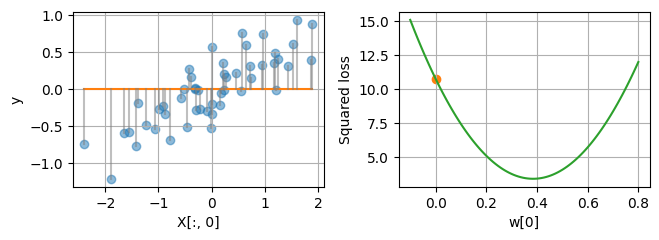

In [ ]:
# Create synthetic data
X, y = create_regression_toy(n_features=1)

plot_1d(X, y, w=[0])

By varying the linear coefficient w, we can change the prediction accuracy of the model, and thus the squared loss.

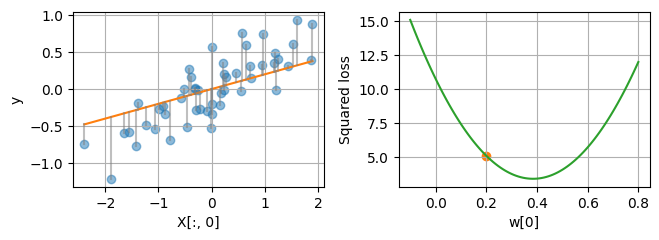

In [ ]:
plot_1d(X, y, w=[0.2])

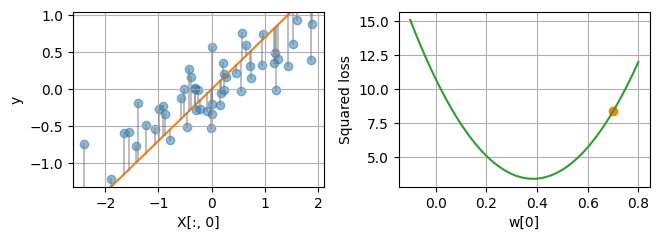

In [ ]:
plot_1d(X, y, w=[0.7])

The linear coefficient leading to the minimum squared loss can be found analytically with the formula:

$$w = (X^\top X)^{-1}X^\top y$$

This is the OLS solution.

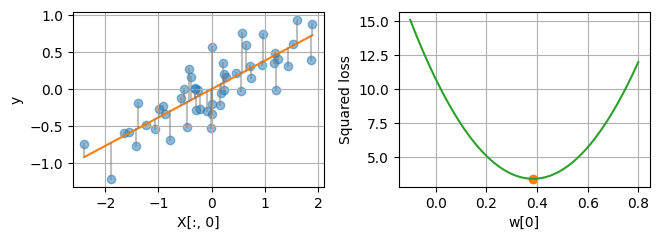

In [ ]:
w_ols = np.linalg.solve(X.T @ X, X.T @ y)

plot_1d(X, y, w=w_ols)

Linear regression can also be used on more than one feature. On the next toy dataset, we will use two features `X[:, 0]` and `X[:, 1]`. The linear regression model is now a *plane*. Here again, summing the squared errors over all samples gives the squared loss. Plotting the squared loss for every value of `w[0]` and `w[1]`leads to a 2D parabola.

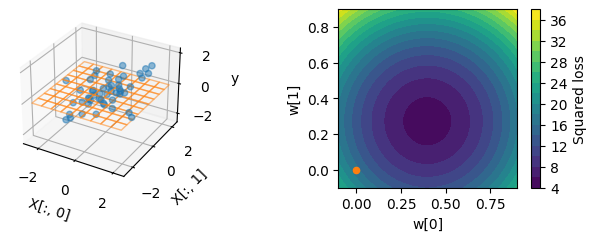

In [ ]:
X, y = create_regression_toy(n_features=2)

plot_2d(X, y, w=[0, 0], show_noiseless=False)

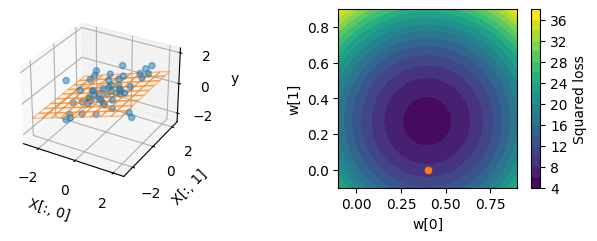

In [ ]:
plot_2d(X, y, w=[0.4, 0], show_noiseless=False)

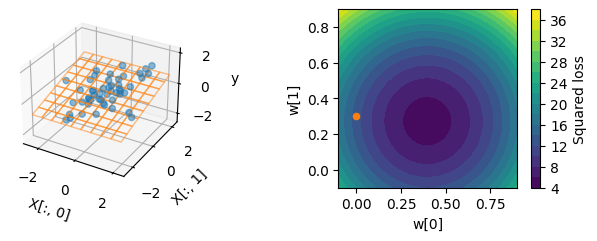

In [ ]:
plot_2d(X, y, w=[0, 0.3], show_noiseless=False)

Here again, the OLS solution can be found analytically with the same formula. Note that the OLS solution is not equal to the ground-truth coefficients used to generate the toy dataset (black cross). This is because we added some noise to the target values `y`. We want the solution we find to be as close as possible to the ground-truth coeffficients, as this will allow the regression to generalize to new data.

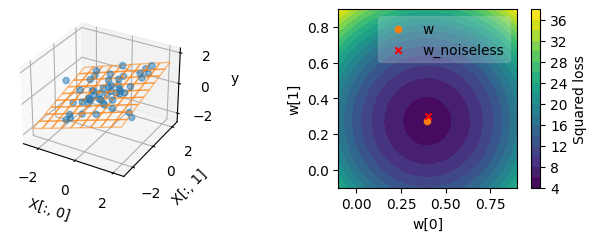

In [ ]:
w_ols = np.linalg.solve(X.T @ X, X.T @ y)
plot_2d(X, y, w=w_ols)

The situation becomes more interesting when the features in `X`are correlated. Here, we add a correlation between the first feature `X[:, 0]`and the second feature `X[:, 1]`. With this correlation, the squared loss function is not isotropic anymore, so the lines of equal loss are now ellipses instead of circles. Thus, when starting from the OLS solution, moving `w` towards the top left leads to a small change in the loss, whereas moving it towards the top right leads to a large change in the loss. This anisotropy makes the OLS solution less robust to noise in some particular directions (deviating more from the ground-truth coefficients).



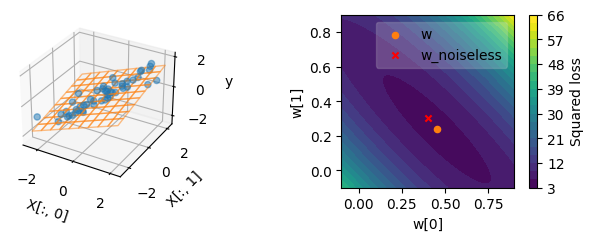

In [ ]:
X, y = create_regression_toy(n_features=2, correlation=0.9)

w_ols = np.linalg.solve(X.T @ X, X.T @ y)
plot_2d(X, y, w=w_ols)

The different robustness to noise can be understood mathematically by the fact that the OLS solution requires inverting the matrix $(X^{\top}X)$. The matrix inversion amounts to inverting the eigenvalues $\lambda_k$ of the matrix. When the features are highly correlated, some eigenvalues $lambda_k$ are close to zero, and a small change in the features can have a large effect on the inverse. Thus, having small eigenvalues reduces the stability of the inversion. If the correlation is even higher, the smallest eigenvalues get closer to zero, and the OLS solution becomes even less stable.

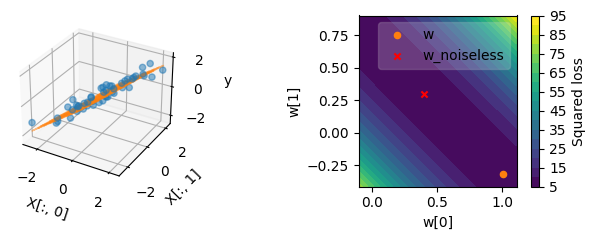

In [ ]:
X, y = create_regression_toy(n_features=2, correlation=0.999)

w_ols = np.linalg.solve(X.T @ X, X.T @ y)
plot_2d(X, y, w=w_ols)

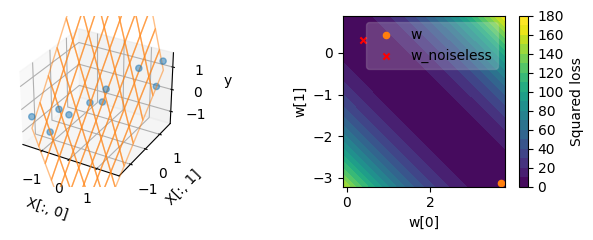

In [ ]:
X, y = create_regression_toy(n_samples=10, n_features=2, correlation=0.999)

w_ols = np.linalg.solve(X.T @ X, X.T @ y)
plot_2d(X, y, w=w_ols)

When the number of features is larger than the number of samples, the linear system becomes under-determined, which means that the OLS problem has an infinite number of solutions, most of which don't generalize well to new data.

## Ridge regression

To solve the instability and under-determinacy issues of OLS, OLS can be extended to *ridge regression*. Ridge regression considers a different optimization problem:
\
\
$$
w = \arg\min_{w}||Xw - y||^2+\alpha||w||^2
$$
\
This optimization problem contains two terms: (i) a *data-fitting term* $||Xw - y||^2$, which ensures the regression correctly fits the training data; and (ii) a regularization term $\alpha||w||^2$, which forces the coefficients $w$ to be close to zero. The regularization term increases the stability of the solution, at the cost of a bias toward zero.
\
\
In the regularization term, `alpha` is a positive hyperparameter that controls the regularization strength. With a smaller `alpha`, the solution will be closer to the OLS solution, and with a larget `alpha`, the solution will be further from the OLS solution and closer to the origin.
\
\
To illustrate this effect, the following plot shows the ridge solution for a particular value of `
alpha`. The black circle corresponds to the line of equal regularization, whereas the blue ellipses are the lines of equal squared loss.

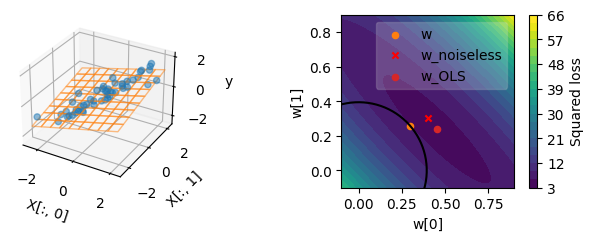

In [ ]:
X, y = create_regression_toy(n_features=2, correlation=0.9)

alpha = 23
w_ridge = np.linalg.solve(X.T @ X + np.eye(X.shape[1]) * alpha, X.T @ y)
plot_2d(X, y, w_ridge, alpha=alpha)

To understand why the regularization term makes the solution more robust to noise, let's consider the ridge solution. The ridge solution can be found analytically with the formula:
\
\
$$ w = (X^{\top}X + \alpha I)^{-1}X^{\top}y $$
\
where $I$ is the identity matrix. In this formula, we can see that the inverted matrix is now $(X^{\top}X + \alpha I)$. Compared to OLS, the additional term $\alpha I$ adds a positive value `alpha` to all eigenvalues $\lambda_k$ of $(X^\top X)$ before the matrix  inversion. Inverting $(\lambda_k +\alpha)$ instead of $\lambda_k$ reduces the instability caused by small eigenvalues. This explains why the ridge solution is more robust to noise than the OLS solution.
\
\
In the following plots, we can see that even with a stronger correlation, the ridge solution is still reasonably close to the noiseless ground truth, while the OLS solution would be far off.

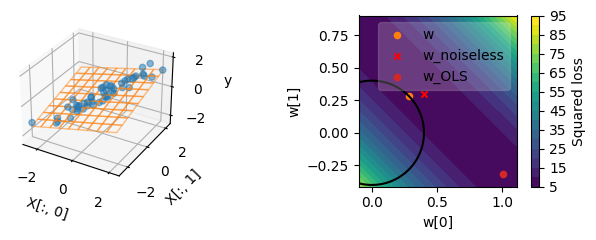

In [ ]:
X, y = create_regression_toy(n_features=2, correlation=0.999)

alpha = 23
w_ridge = np.linalg.solve(X.T @ X + np.eye(X.shape[1]) * alpha, X.T @ y)
plot_2d(X, y, w_ridge, alpha=alpha)

Changing the regularization hyperparameter $\alpha$ leads to another ridge solution.

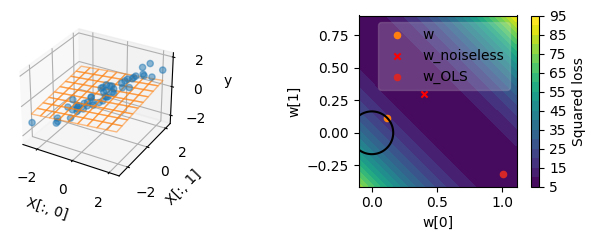

In [ ]:
X, y = create_regression_toy(n_features=2, correlation=0.999)

alpha = 200
w_ridge = np.linalg.solve(X.T @ X + np.eye(X.shape[1]) * alpha, X.T @ y)
plot_2d(X, y, w_ridge, alpha=alpha)

## Hyperparameter selection

One issue with ridge regression is that the hyperparameter $\alpha$ is arbitrary. Different choices of hyperparameters lead to different models. To compare these models, we cannot compare the ability to fit the training data, because the best model would just be OLS ($\alpha = 0$). Instead, we want to compare the ability of each model to generalize to new data. To estimate a model's ability to generalize, we can compute its prediction accuracy on a separate dataset that was not used during the model fitting (i.e. not used to find the coefficients $w$).

To illustrate this idea, let's split the dataset into two subsets.

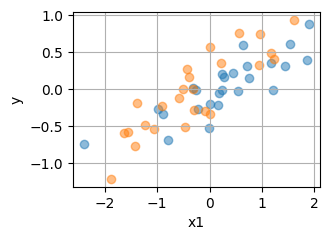

In [ ]:
X, y = create_regression_toy(n_features=1)

plot_kfold2(X, y, fit=False)

Then, we can fit a model on each subset.

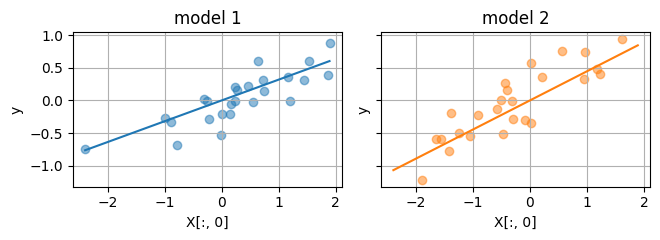

In [ ]:
alpha = 0.1
plot_kfold2(X, y, alpha, fit=True)

And compute the prediction accuracy of each model on the other subset (its *generalization*).

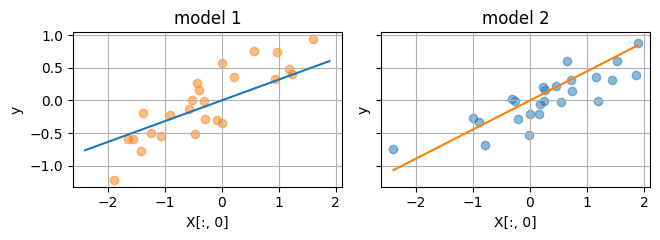

In [ ]:
plot_kfold2(X, y, alpha, fit=True, flip=True)

In this way, we can evaluate the ridge regression (fit with a specific $\alpha$) on its ability to generalize to new data. If we do that for different hyperparameter candidates $\alpha$, we can select the model leading to the best out-of-set prediction accuracy.

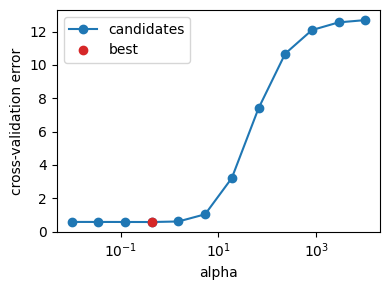

In [ ]:
noise = 0.1
X, y = create_regression_toy(n_features=2, noise=noise)
plot_cv_path(X, y)

In the example above, the noise level is low, so the best $\alpha$ is close to zero, and ridge regression is not much better than OLS. However, if the dataset has more noise, a lower number of samples, or more correlated features, the best hyperparameter can be higher. In this case, ridge regression is better than OLS.

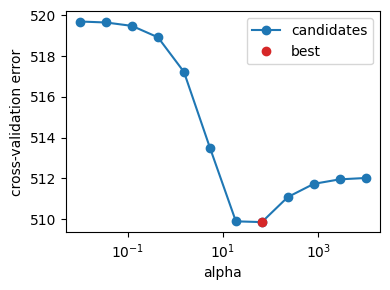

In [ ]:
noise = 3
X, y = create_regression_toy(n_features=2, noise=noise)
plot_cv_path(X, y)

When the noise level is too high, the best hyperparameter can be the largest on the grid. It either means that the grid is too small, or that the regression does not find a predictive link between the features and the target. In this case, the model with the lowest generalization error always predicts zero ($w = 0$). Notice the values of the cross-validation error on the y-axis!

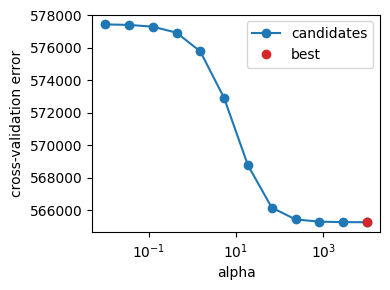

In [ ]:
noise = 100
X, y = create_regression_toy(n_features=2, noise=noise)
plot_cv_path(X, y)

To summarize, to select the best hyperparameter $\alpha$, the standard method is to perform a grid search:
- Split the training set into two subsets: one subset used to fit the models, and one subset to estimate the prediction accuracy (*validation set*)
- Define a number of hyperparameter candidates, for example [0.1, 1, 10, 100].
- Fit a separate ridge regression model with each hyperparameter candidate $\alpha$.
- Compute the prediction accuracy on the validation set.
- Select the hyperparameter candidate leading to the best validation accuracy.

\
To make the grid search less sensitive to the choice of how the training data was split, the process can be repeated for multiple splits. Then, the different prediction accuracies can be averaged over splits before the hyperparameter selection, for a more robust estimate of a given $\alpha$'s accuracy.
Thus, the process is called a *cross-validation*.
\
\
Learn more about hyperparameter selection and cross-validation on the [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html).

# Hyperparameter search on our own dataset

Ok, enough with toy data! Let's return to our fMRI dataset, and implement hyperparameter search on it. Let's see if any value of $\alpha$ can help us improve performance on our test set.

In [ ]:
def generate_leave_one_run_out(n_samples, n_runs, random_seed=None):
  """
  This function is a generator that yields partitions of the data.
  Each 'run' (a slice of the data) is used as the validation set in turn.
  The rest of the data is used as the training set.
  """

  np.random.seed(random_seed)

  run_length = np.ceil(n_samples/n_runs).astype(int)
  run_onsets = np.arange(0, n_samples, run_length)

  all_val_runs = np.random.permutation(n_runs)

  all_samples = np.arange(n_samples)
  runs = np.split(all_samples, run_onsets[1:])

  for val_run in all_val_runs:
    train = np.hstack(
        [runs[jj] for jj in range(n_runs) if jj != val_run])
    val = np.hstack([runs[jj] for jj in range(n_runs) if jj == val_run])
    yield train, val

As cross-validation is computationally heavy, we restrict this analysis to a single subject and hemisphere.

In [ ]:
subj = 1 # @param [1, 2, 3, 4, 5, 6, 7, 8]
hemisphere = 'left' # @param ["left", "right"]

subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

fmri_data = np.load(os.path.join(subj_dir,
                               hemisphere[0]+'h_training_fmri.npy'))

fmri_train = fmri_data[idxs_train]
fmri_test = fmri_data[idxs_test]

In [ ]:
# Extract features from our model (no PCA here as it will be done later!)
features_train = extract_features(feat_extractor, train_imgs_dataloader, pca=None)
features_test = extract_features(feat_extractor, test_imgs_dataloader, pca=None)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Define hyperparameter grid search

We use [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from `scikit-learn` to perform our hyperparameter search. Given an estimator (in our case, a `pipeline` comprising PCA and ridge regression) it applies it across folds in a cross-validated way. It then selects the hyperparameter (in our case, $\alpha$) value with the best performance.

Notice that here, we have the PCA as part of the pipeline, instead of using our own function implemented earlier. This is to make it interface more nicely with the `scikit-learn` pipeline.

In [ ]:
# Define a hyperparameter grid with the values of alpha that we want to try
alphas = [0., 0.1, 1.0, 10., 20., 40.]
hyperparam_grid={'ridge__alpha': alphas}

# Keep n. components fixed, although we could potentially also do a grid search
n_components = 100 #@param

# Define a pipeline combining PCA and ridge regression
pca_ridge_pipe = make_pipeline(
    PCA(n_components=n_components),
    Ridge()
)

n_samples = len(idxs_train)
n_runs = 5
cv = generate_leave_one_run_out(n_samples, 5, random_seed=rand_seed)
cv = check_cv(cv)

grid_search = GridSearchCV(pca_ridge_pipe, hyperparam_grid, cv=cv)

In [ ]:
grid_search.fit(features_train, fmri_train)

GridSearchCV(cv=_CVIterableWrapper(cv=[(array([  0,   1, ..., 783, 784]), array([157, 158, ..., 312, 313])), (array([  0,   1, ..., 783, 784]), array([471, 472, ..., 626, 627])), (array([  0,   1, ..., 626, 627]), array([628, 629, ..., 783, 784])), (array([157, 158, ..., 783, 784]), array([  0,   1, ..., 155, 156])), (array([  0,   1, ..., 783, 784]), array([314, 315, ..., 469, 470]))]),
             estimator=Pipeline(steps=[('pca', PCA(n_components=100)),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.0, 0.1, 1.0, 10.0, 20.0, 40.0]})

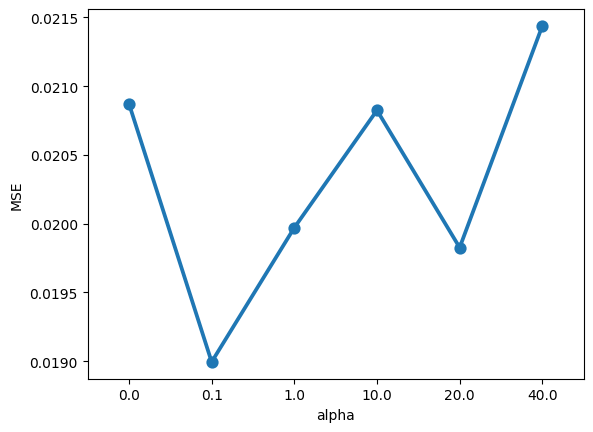

In [ ]:
mean_mse = -grid_search.cv_results_['mean_test_score']
sns.pointplot(x=alphas, y=mean_mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

We can see that 10 is the best value for $\alpha$ based on our grid search. If we now call `grid_search.predict()` on the held-out test set, it will directly use the best hyperparameter.



In [ ]:
fmri_pred = grid_search.predict(features_test)
corrs = compute_correlation(fmri_pred, fmri_test)

In [ ]:
# Let's visualize the prediction-target correlations over the brain surface map.
view = plot_surf_map(stat_map=corrs, subj=subj,
                     hemi=hemisphere)
view

Output hidden; open in https://colab.research.google.com to view.

**OPTIONAL EXERCISE:** try integrating the grid search with our code from earlier to perform a grid search for each participant, and see how well the resulting ridge regressions perform on our two ROIs. Also check the best performing alphas: are they the same across participants and hemispheres?

# Sentence embedding models
Our visual system is not a simple object categorization neural network: it represents several semantically complex aspects of real-world scenes, particularly in the higher visual areas. Recently, [a paper](https://arxiv.org/abs/2209.11737) by Adrien Doerig and colleagues has shown that sentence embeddings, high-dimensional representations of scene descriptions extracted by language models, can predict fMRI activity in the visual system extremely well. This is surprising, since these models never received the images as input, only their descriptions, and in turn participants in the scanner never read the descriptions, they only saw the images!

<img src='https://drive.google.com/uc?id=1-1OKCVBZ22cf1NBN1q1mn_4gsxbkPI5B' width=400>

Now, we will run an experiment similar to that of Doerig et al., and use embeddings of scene captions to predict fMRI data from the visual system. As the NSD images are taken from COCO, we have access to those captions!

Let's start by creating a dataset to load the captions, and an Embedder class to wrap our language models, similar to the FeatureExtractor class we implemented for the vision models earlier. We use the [SentenceTransformers](https://sbert.net/) library to easily get our models.

In [ ]:
class CaptionDataset(Dataset):
    def __init__(self, captions_file, idxs):
        self.captions = pd.read_csv(captions_file).iloc[idxs]

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        c1 = self.captions.iloc[idx]['caption_1']
        c2 = self.captions.iloc[idx]['caption_2']
        c3 = self.captions.iloc[idx]['caption_3']
        c4 = self.captions.iloc[idx]['caption_4']
        c5 = self.captions.iloc[idx]['caption_5']

        return c1, c2, c3, c4, c5

In [ ]:
class Embedder():
  """
  Simple wrapper class for
  sentence embedding models.
  """
  def __init__(self, modelname, device=device):
    self.modelname = modelname
    self.device = device
    model = SentenceTransformer(modelname)
    self.model = model.to(self.device)

  def __call__(self, x):

    embeds = [self.model.encode(list(i)) for i in x]

    # Average across 5 captions
    embeds = np.mean(np.dstack(embeds), axis=2)

    return embeds

## Choose a language model

Again, you can read the literature on these models to find out differences between them, and whether anyone has tried fitting them to brain data before!

In [ ]:
lang_model_name = 'all-MiniLM-L6-v2' #@param ['all-mpnet-base-v2', 'all-MiniLM-L6-v2', 'average_word_embeddings_komninos', 'sentence-t5-large'] {allow-input: true}

embedder = Embedder(lang_model_name, device=device)

## Create train and test dataloaders

Here, we reuse the train/test partition defined above.

In [ ]:
captions_path = os.path.join(main_dir, 'additional_data', 'nsdcaptions.csv')

# The DataLoaders contain the ImageDataset class
train_capts_dataloader = DataLoader(
    CaptionDataset(captions_path, idxs_train),
    batch_size=batch_size
)
test_capts_dataloader = DataLoader(
    CaptionDataset(captions_path, idxs_test),
    batch_size=batch_size
)

## Reduce dimensionality using PCA

As before, since the embeddings are high-dimensional, we reduce their dimensionality using PCA. Their dimensionality is not *as* high as the DNN features we saw earlier, so we only use 20 components.

In [ ]:
n_components = 20 # @param

pca_lang = fit_pca(embedder, train_capts_dataloader,
              n_components=n_components, batch_size=100)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
embeddings_train = extract_features(embedder, train_capts_dataloader, pca=pca_lang)
embeddings_test = extract_features(embedder, test_capts_dataloader, pca=pca_lang)

print('\nTraining images features:')
print(embeddings_train.shape)
print('(Training stimulus images × PCA features)')

print('\nTest images features:')
print(embeddings_test.shape)
print('(Test stimulus images × PCA features)')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Training images features:
(785, 20)
(Training stimulus images × PCA features)

Test images features:
(87, 20)
(Test stimulus images × PCA features)


Now, we compute the embedding model's performance on each of our two ROIs, across participants.

In [ ]:
roi_1 = 'early' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
roi_2 = 'ventral' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

prediction_df = []

for subj in tqdm(range(1, 9)):
  lh_corrs, rh_corrs, _, _ = fit_and_predict(subj, embeddings_train, embeddings_test,
                                       idxs_train, idxs_test)
  roi1_lh = get_roi_mask(roi_1, 'lh', subj)[0][:len(lh_corrs)]
  roi2_lh = get_roi_mask(roi_2, 'lh', subj)[0][:len(lh_corrs)]
  roi1_rh = get_roi_mask(roi_1, 'rh', subj)[0][:len(rh_corrs)]
  roi2_rh = get_roi_mask(roi_2, 'rh', subj)[0][:len(rh_corrs)]

  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(lh_corrs[np.where(roi1_lh)[0]]),
      'hemisphere': 'left',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(rh_corrs[np.where(roi1_rh)[0]]),
      'hemisphere': 'right',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(lh_corrs[np.where(roi2_lh)[0]]),
      'hemisphere': 'left',
      'roi': roi_2
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(rh_corrs[np.where(roi2_rh)[0]]),
      'hemisphere': 'right',
      'roi': roi_2
  })

prediction_df = pd.DataFrame(prediction_df)

  0%|          | 0/8 [00:00<?, ?it/s]

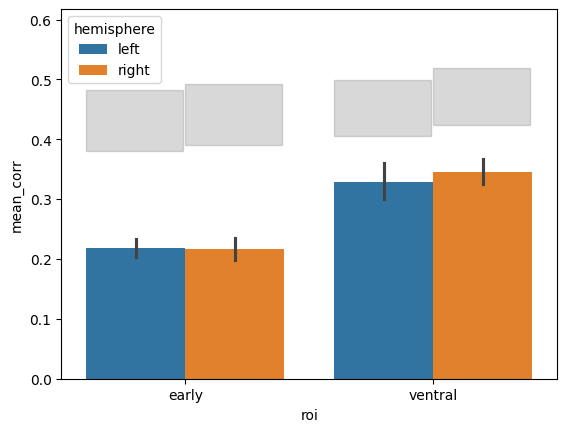

In [ ]:
barplot(prediction_df, noise_ceilings=all_noiseceilings)

We can notice a pattern opposite to what we saw earlier: now, *ventral* visual cortex is predicted much better than early visual cortex. Given that these representations are less visual and more "semantic", this makes sense!

# Variance partitioning

After having tried these two very different models, a question might have popped in your mind: how do we directly compare them? Do they play unique roles? They might be explaining the same variance in the data: after all, visual features and semantic aspects are highly correlated, e.g. whenever the word "elephant" appears, something big and gray will be in the image (see [this paper](https://jov.arvojournals.org/article.aspx?articleid=2785568) for an analysis of these correlations on the NSD).

**Variance partitioning** is a simple method that attempts to answer this question. The idea is to take the variance explained by two models together (e.g. the concatenated vision and language features), and subtract from that the variance explained by each single model:

<img src='https://drive.google.com/uc?id=1-2KwQFk1MNFW1c-CMhrbTXhcTGErJjkM' width=500>

Whatever remains is the *unique variance* of the other model. The *shared variance* between models, on the other hand, is the sum of the variance explained by both unique models, minus the variance explained by the joint model. If this sounds confusing, [this blog post](http://lytarhan.rbind.io/post/variancepartitioning/) provides a great introduction to the topic. Once the idea is clear, let's dive into the code!

Some examples of the use of variance partitioning in the literature:

- [This paper](https://www.frontiersin.org/articles/10.3389/fncom.2015.00135/full) uses it to find that much of the variance in scene-selective visual cortex is shared between low-level visual features (Fourier power) and high-level, 3D aspects of the scene (subjective distance)

- [This paper](https://www.sciencedirect.com/science/article/pii/S0896627318309954) uses it to distinguish between low-level and 3D features in predicting different areas of the visual cortex.

- [This paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009267) uses it to compare the ability of models trained for different tasks (e.g. segmentation, opbject recognition, depth prediction) in explaining visual cortex representations.

- [This paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006111) uses it to disentangle deep net features and a model based on navigational affordances in explaining activity in scene-selective visual cortex.

## Helper functions to partition the variance

We define a helper function to convert correlation coefficients to $R^2$, and another to perform the summations and subtractions illustrated in the figure above. This function takes as input the correlations estimated by all three models (only A, only B, A & B).

In [ ]:
def get_rsquareds(corrs):
    """
    Convert correlations to R^2
    """

    return np.square(corrs) * np.sign(corrs)


def partition_variance(r_A, r_B, r_AUB,
                       compute_rsquared=True):
    """
    Partition variance by subtracting
    variance explained by single models
    from that explained by both models jointly.

    args:
    - r_A: correlations (or rsquareds) for model A
    - r_B: same for model B
    - r_AUB: correlations/rsquareds for concatenated models
    - compute_rsquared: set to True when the inputs are correlations,
        False if they are already rsquareds
    """

    if compute_rsquared:
        r_A = get_rsquareds(r_A)
        r_B = get_rsquareds(r_B)
        r_AUB = get_rsquareds(r_AUB)

    uniquevars_A = r_AUB - r_B
    uniquevars_B = r_AUB - r_A
    sharedvars = r_A + r_B - r_AUB

    return uniquevars_A, uniquevars_B, sharedvars

We also define a function that extracts features from two models simultaneously
(similar to our `extract_features` function above):




In [ ]:
def extract_mixedfeatures(feat_extr1, feat_extr2,
                          dataloader1, dataloader2, pca1=None, pca2=None):
  """
  Extract the features from two models in parallel
  """

  features1 = []
  features2 = []
  for d1, d2 in tqdm(zip(dataloader1, dataloader2), total=len(dataloader1)):
    # Extract features
    ft1 = feat_extr1(d1)
    ft2 = feat_extr2(d2)

    if pca1 is not None:
      # Apply PCA transform (optional)
      ft1 = pca1.transform(ft1)
    if pca2 is not None:
      # Apply PCA transform (optional)
      ft2 = pca2.transform(ft2)

    features1.append(ft1)
    features2.append(ft2)

  return np.vstack(features1), np.vstack(features2)

In [ ]:
# @title Choose vision model and layer(s)
visionmodel = 'alexnet' #@param ['alexnet', 'resnet50', 'clip'] {allow-input: true}
target_layers = 'features.2' #@param {type: 'string'}

# Note that target_layers can be a list of strings.
# To find out what layers are available, you can do

In [ ]:
# @title Choose language model
langmodel = 'all-MiniLM-L6-v2' #@param ['all-mpnet-base-v2', 'all-MiniLM-L6-v2', 'average_word_embeddings_komninos', 'sentence-t5-large'] {allow-input: true}

lang_embedder = Embedder(lang_model_name, device=device)

In [ ]:
# Create image feature extractor
feat_extractor_img = FeatureExtractor(visionmodel, device=device, target_layers=target_layers)

# Create language embedder
feat_extractor_lang = Embedder(langmodel, device=device)

In [ ]:
n_components_img = 100 # @param

img_pca = fit_pca(feat_extractor_img, train_imgs_dataloader,
              n_components=n_components_img, batch_size=batch_size)

In [ ]:
n_components_lang = 20 # @param

lang_pca = fit_pca(feat_extractor_lang, train_capts_dataloader,
                   n_components=n_components_lang, batch_size=batch_size)

In [ ]:
img_feats_train, lang_feats_train = extract_mixedfeatures(feat_extractor_img, feat_extractor_lang,
                                                          train_imgs_dataloader, train_capts_dataloader,
                                                          pca1=img_pca, pca2=lang_pca)
img_feats_test, lang_feats_test = extract_mixedfeatures(feat_extractor_img, feat_extractor_lang,
                                                      test_imgs_dataloader, test_capts_dataloader,
                                                      pca1=img_pca, pca2=lang_pca)

In [116]:
print('\nTraining images features:')
print(img_feats_train.shape)
print('\nTraining language features:')
print(lang_feats_train.shape)

print('\nTest images features:')
print(img_feats_test.shape)
print('\nTest language features:')
print(lang_feats_test.shape)


Training images features:
(785, 100)

Training language features:
(785, 20)

Test images features:
(87, 100)

Test language features:
(87, 20)


## Run variance partitioning for each subject and ROI

In [ ]:
roi_1 = 'early' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
roi_2 = 'ventral' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

prediction_df = []

for subj in tqdm(range(1, 9)):

  lh_corrs_vis, rh_corrs_vis, _, _ = fit_and_predict(subj, img_feats_train, img_feats_test,
                                              idxs_train, idxs_test)
  lh_corrs_lang, rh_corrs_lang, _, _ = fit_and_predict(subj, lang_feats_train, lang_feats_test,
                                                 idxs_train, idxs_test)
  lh_corrs_both, rh_corrs_both, _, _ = fit_and_predict(subj, np.hstack((img_feats_train, lang_feats_train)),
                                                 np.hstack((img_feats_test, lang_feats_test)),
                                                 idxs_train, idxs_test)

  lh_unique_vis, lh_unique_lang, lh_shared = partition_variance(lh_corrs_vis, lh_corrs_lang, lh_corrs_both,
                                                                compute_rsquared=True)
  rh_unique_vis, rh_unique_lang, rh_shared = partition_variance(rh_corrs_vis, rh_corrs_lang, rh_corrs_both,
                                                                compute_rsquared=True)

  roi1_lh = get_roi_mask(roi_1, 'lh', subj)[0][:len(lh_unique_vis)]
  roi2_lh = get_roi_mask(roi_2, 'lh', subj)[0][:len(lh_unique_vis)]
  roi1_rh = get_roi_mask(roi_1, 'rh', subj)[0][:len(rh_unique_vis)]
  roi2_rh = get_roi_mask(roi_2, 'rh', subj)[0][:len(rh_unique_vis)]

  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(lh_unique_vis[np.where(roi1_lh)[0]]),
      'model': 'unique_vis',
      'hemisphere': 'left',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(lh_unique_lang[np.where(roi1_lh)[0]]),
      'model': 'unique_lang',
      'hemisphere': 'left',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(lh_shared[np.where(roi1_lh)[0]]),
      'model': 'shared',
      'hemisphere': 'left',
      'roi': roi_1
  })

  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(rh_unique_vis[np.where(roi1_rh)[0]]),
      'model': 'unique_vis',
      'hemisphere': 'right',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(rh_unique_lang[np.where(roi1_rh)[0]]),
      'model': 'unique_lang',
      'hemisphere': 'right',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(rh_shared[np.where(roi1_rh)[0]]),
      'model': 'shared',
      'hemisphere': 'right',
      'roi': roi_1
  })

  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(lh_unique_vis[np.where(roi2_lh)[0]]),
      'model': 'unique_vis',
      'hemisphere': 'left',
      'roi': roi_2
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(lh_unique_lang[np.where(roi2_lh)[0]]),
      'model': 'unique_lang',
      'hemisphere': 'left',
      'roi': roi_2
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(lh_shared[np.where(roi2_lh)[0]]),
      'model': 'shared',
      'hemisphere': 'left',
      'roi': roi_2
  })

  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(rh_unique_vis[np.where(roi2_rh)[0]]),
      'model': 'unique_vis',
      'hemisphere': 'right',
      'roi': roi_2
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(rh_unique_lang[np.where(roi2_rh)[0]]),
      'model': 'unique_lang',
      'hemisphere': 'right',
      'roi': roi_2
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'variance_explained': np.mean(rh_shared[np.where(roi2_rh)[0]]),
      'model': 'shared',
      'hemisphere': 'right',
      'roi': roi_2
  })



prediction_df = pd.DataFrame(prediction_df)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
barplot(prediction_df[prediction_df['hemisphere']=='left'], x='roi', y='variance_explained',
        hue='model', title='Left hemisphere')

In [ ]:
barplot(prediction_df[prediction_df['hemisphere']=='right'], x='roi', y='variance_explained',
        hue='model', title='Right hemisphere')

We can notice several interesting things:
- In early visual cortex, most variance is either shared between image features and language features, or it's unique to image features (not too surprising). However, there is a small but non-zero amount of variance explained uniquely by language features!
- In ventral visual cortex, conversely, most variance is either unique to language features or shared between vision and language.

We also notice something odd: in ventral visual cortex, the amount of unique variance explained by image features is actually **negative**! This means that the variance explained by two models together is less than that explained by one of them alone. This can happen, as Leyla Tarhan explains nicely in her [blog post](http://lytarhan.rbind.io/post/variancepartitioning/), when we use separate train and test partitions, and variance explained is thus a measure of *generalization*. If we have too many redundant features, as can be the case with the two concatenated models, the model can overfit to the training set, meaning that it will perform worse on the test set than a simpler model.

Negative unique explained variance is thus a symptom of **overfitting**: can you think of ways, that we have looked at, to reduce overfitting?
\
\
**EXERCISE:** try to reduce overfitting using some of the tools we have learned in this tutorial. The negative explained variance should disappear!

## Conclusion

In this tutorial, we have shown how brain data can be predicted by qualitatively very different models. One model extracted features from the images participants saw in the scanner, the other from descriptions of those images. As expected, each was best suited to predict a different part of the visual cortex: for the vision model, it was the early regions. For the language model, the later regions, more sensitive to semantics.

Of course, this approach is in no way limited to deep neural networks. Any kind of feature, as long as it can be expressed as a vector, can be used to predict brain data using a linear regression.

For a very exhaustive exploration of different models' ability to predict visual cortical activity, see [this paper](https://www.biorxiv.org/content/10.1101/2022.03.28.485868v2.abstract) by Colin Conwell et al.

# Advanced: Fit banded ridge model

This section is based on [this tutorial](https://github.com/gallantlab/voxelwise_tutorials/blob/main/tutorials/notebooks/shortclips/06_plot_banded_ridge_model.ipynb) by the Gallant Lab.

\

The banded ridge model (proposed in [this paper](https://www.biorxiv.org/content/10.1101/386318v1.full)) is a generalization of ridge regression that allows for different feature spaces (e.g. the features coming from different models) to have different scaling hyperparameters. How much each model contributes to the explained variance can thus be determined.

Just like with standard ridge regression, we determine the optimal hyperparameters using cross-validation. However, we will use slightly more sophisticated tools than for vanilla ridge regression. We will also use the [himalaya](https://github.com/gallantlab/himalaya) package besides scikit-learn.



In [ ]:
!pip install himalaya

In [ ]:
from himalaya.backend import set_backend
from himalaya.kernel_ridge import MultipleKernelRidgeCV, Kernelizer, ColumnKernelizer
from himalaya.scoring import r2_score_split

In [ ]:
backend = set_backend('torch_cuda') if device == 'cuda' else set_backend('numpy')

Pick a solver to search for the best hyperparameters. Here we just use random search, however feel free to explore other options in the himalaya documentation.

In [ ]:
# Here we will use the "random_search" solver.
solver = "random_search"

# We can check its specific parameters in the function docstring:
solver_function = MultipleKernelRidgeCV.ALL_SOLVERS[solver]
print("Docstring of the function: %s" % solver_function.__name__)
print(solver_function.__doc__)

As before, we generate our cross validation splits:

In [ ]:
n_samples = len(idxs_train)
cv = generate_leave_one_run_out(n_samples, 5, random_seed=rand_seed)
cv = check_cv(cv)

In [ ]:
n_iter = 20

alphas = np.logspace(1, 20, 20)

In [ ]:
n_targets_batch = 100
n_alphas_batch = 5
n_targets_batch_refit = 100

In [ ]:
solver_params = dict(n_iter=n_iter, alphas=alphas,
                     n_targets_batch=n_targets_batch,
                     n_alphas_batch=n_alphas_batch,
                     n_targets_batch_refit=n_targets_batch_refit)

mkr_model = MultipleKernelRidgeCV(kernels="precomputed", solver=solver,
                                  solver_params=solver_params, cv=cv)

In [ ]:
# @title Choose vision model and layer(s)
visionmodel = 'alexnet' #@param ['alexnet', 'resnet50', 'clip'] {allow-input: true}
target_layers = 'features.2' #@param {type: 'string'}

# Note that target_layers can be a list of strings.
# To find out what layers are available, you can do

In [ ]:
# @title Choose language model
langmodel = 'all-MiniLM-L6-v2' #@param ['all-mpnet-base-v2', 'all-MiniLM-L6-v2', 'average_word_embeddings_komninos', 'sentence-t5-large'] {allow-input: true}

lang_embedder = Embedder(lang_model_name, device=device)

In [ ]:
# Create image feature extractor
feat_extractor_img = FeatureExtractor(visionmodel, device=device, target_layers=target_layers)

# Create language embedder
feat_extractor_lang = Embedder(langmodel, device=device)

In [ ]:
n_components_img = 100 # @param

img_pca = fit_pca(feat_extractor_img, train_imgs_dataloader,
              n_components=n_components_img, batch_size=batch_size)

In [ ]:
n_components_lang = 20 # @param

lang_pca = fit_pca(feat_extractor_lang, train_capts_dataloader,
                   n_components=n_components_lang, batch_size=batch_size)

In [ ]:
img_feats_train, lang_feats_train = extract_mixedfeatures(feat_extractor_img, feat_extractor_lang,
                                                          train_imgs_dataloader, train_capts_dataloader,
                                                          pca1=img_pca, pca2=lang_pca)
img_feats_test, lang_feats_test = extract_mixedfeatures(feat_extractor_img, feat_extractor_lang,
                                                      test_imgs_dataloader, test_capts_dataloader,
                                                      pca1=img_pca, pca2=lang_pca)

In [ ]:
print('\nTraining images features:')
print(img_feats_train.shape)
print('\nTraining language features:')
print(lang_feats_train.shape)

print('\nTest images features:')
print(img_feats_test.shape)
print('\nTest language features:')
print(lang_feats_test.shape)

Now we define our banded ridge regression, combining the features of the two models.

In [ ]:
model_names = ['vision', 'language']
slices = [slice(0, n_components_img), slice(n_components_img+1, n_components_img+n_components_lang)]
kernelizer = Kernelizer(kernel='linear')
kernelizers_tuples = [(name, kernelizer, slice_) for name, slice_ in zip(model_names, slices)]
column_kernelizer = ColumnKernelizer(kernelizers_tuples)

In [ ]:
# Visualize the kernelizer
column_kernelizer

In [ ]:
pipeline = make_pipeline(
    column_kernelizer,
    mkr_model,
)
pipeline

## Pick subject
As this is also a computationally intense pipeline, we run a single subject.

In [ ]:
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

In [ ]:
lh_corrs_both, rh_corrs_both, pipe_lh, pipe_rh = fit_and_predict(subj, np.hstack((img_feats_train, lang_feats_train)),
                                                 np.hstack((img_feats_test, lang_feats_test)),
                                                 idxs_train, idxs_test, regression=pipeline)

## Plot the banded ridge split

Besides improving prediction accuracy, banded ridge regression provides a way to disentangle the contribution of the two feature spaces. To do so, we take the kernel weights and the ridge (dual) weights corresponding to each feature space, and use them to compute the prediction from each feature space separately.

$$
\hat{y} = \sum_i^{m}\hat{y}_i = \sum_i^{m}\gamma_iK_i\hat{w}
$$

Then, we use these split predictions to compute split $\tilde{R}_i^2$ scores. These scores are corrected so that their sum is equal to the $R^2$ score of the full prediction $\hat{y}$.

In [ ]:
split_scores_mask = {}

Y_test_pred_split_lh = pipe_lh.predict(np.hstack((img_feats_test, lang_feats_test)), split=True)
split_scores_mask['left'] = backend.to_numpy(r2_score_split(lh_fmri_test, Y_test_pred_split_lh))

Y_test_pred_split_rh = pipe_rh.predict(np.hstack((img_feats_test, lang_feats_test)), split=True)
split_scores_mask['right'] = backend.to_numpy(r2_score_split(rh_fmri_test, Y_test_pred_split_rh))

In [ ]:
hemisphere = 'left' #@param ["left", "right"]

view = plot_surf_map(stat_map=split_scores_mask[hemisphere][0],
                     subj=subj, hemi=hemisphere, title='Vision model scores')
view

In [ ]:
hemisphere = 'left' #@param ["left", "right"]

view = plot_surf_map(stat_map=split_scores_mask[hemisphere][1],
                     subj=subj, hemi=hemisphere, title='Language model scores')
view

What can you see by looking at these brain maps? Where does the vision model perform better, and where does the language model perform better instead?

In this final part of the tutorial, we have seen another method, beyond variance partitioning, to disentangle the roles of different models in predicting fMRI data. As in cognitive science and AI we are often dealing with messy real-world datasets, where variables often correlate with each other, disentangling the contributions of different models is a problem we will constantly face!